Based on DensePose-COCO annotations visualization notebook.

The densepose COCO dataset annotations are provided within the coco annotation framework and can be handled directly using the pycocotools.


### DensePose fields in annotations:
#### Collected Masks
* **'dp_masks' :**  RLE encoded dense masks. All part masks are of size 256x256 and are mapped to 14 labels. Please note that these are not linked to the 3D template. These are semantically meaningful parts collected from annotators, we use these to sample annotation points.

#### More info about annotations (format and API) 
http://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch

https://github.com/facebookresearch/DensePose/blob/master/challenge/2018_PoseTrack_DensePose/data_format.md

http://cocodataset.org/#download


In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util

from random import randint
from pycocotools.coco import COCO

In [2]:
os.chdir("/densepose")
coco_folder = 'detectron/datasets/data/coco/'

In [3]:
!pwd

/densepose


Select a random image, read it and load the annotations that correspond to this image.

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
COCO_val2014_000000368752.jpg


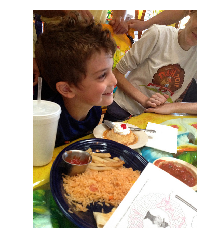

In [4]:
dp_coco = COCO( coco_folder + 'annotations/densepose_coco_2014_minival.json')

# Get img id's for the minival dataset.
im_ids = dp_coco.getImgIds()
# Select a random image id.
Selected_im = im_ids[21]#randint(0, len(im_ids))] # Choose im no 57 to replicate 
# Load the image
im = dp_coco.loadImgs(Selected_im)[0]  
# Load Anns for the selected image.
ann_ids = dp_coco.getAnnIds( imgIds=im['id'] )
anns = dp_coco.loadAnns(ann_ids)
# Now read and b
print(im['file_name'])
im_name = os.path.join( coco_folder + 'val2017', im['file_name'].split("_")[-1] )
I=cv2.imread(im_name)
plt.imshow(I[:,:,::-1]); plt.axis('off'); plt.show()

## Visualization of Collected Masks

Let's visualize the collected masks on the image. 

These masks are used:
* to sample points to collect dense correspondences.
* as an auxillary loss in DensePose-RCNN.
* to obtain dense FG/BG maps.

In [5]:
category_to_id = {
    "Torso": 0,
    "RightHand": 1,
    "LeftHand": 2,
    "LeftFoot": 3,
    "RightFoot": 4,
    "UpperLegRight": 5,
    "UpperLegLeft": 6,
    "LowerLegRight": 7,
    "LowerLegLeft": 8,
    "UpperArmLeft": 9,
    "UpperArmRight": 10,
    "LowerArmLeft": 11,
    "LowerArmRight": 12,
    "Head": 13,
    "Person": 14
}
id_to_category = {category_to_id[key]: key for key in category_to_id}
category_to_id

{'Head': 13,
 'LeftFoot': 3,
 'LeftHand': 2,
 'LowerArmLeft': 11,
 'LowerArmRight': 12,
 'LowerLegLeft': 8,
 'LowerLegRight': 7,
 'Person': 14,
 'RightFoot': 4,
 'RightHand': 1,
 'Torso': 0,
 'UpperArmLeft': 9,
 'UpperArmRight': 10,
 'UpperLegLeft': 6,
 'UpperLegRight': 5}

In [6]:
# Functions to get dense masks and bounding boxes from the decoded masks.
def GetDensePoseMask(Polys):
    MaskGen = np.zeros([256,256])
    print(len(Polys))
    for i in range(1,15):
        if(Polys[i-1]):
            current_mask = mask_util.decode(Polys[i-1])
            MaskGen[current_mask>0] = i
    return MaskGen


def GetDensePoseBbox(Polys):
    """ Converts densepose mask annotation to 14 body parts bboxes """
    parts_bboxes = {}
    parts_masks = {}
    parts_RLEmasks = {}
    parts_area = {}
    
    for i in range(14):
        if Polys[i]:
#             mask = mask_util.decode(Polys[i])
            parts_masks[i] = mask_util.decode(Polys[i])
            parts_bboxes[i] = mask_util.toBbox(Polys[i])
#             parts_bboxes[i] = mask_util.toBbox(parts_masks[i])
            parts_area[i] = mask_util.area(Polys[i])
            parts_RLEmasks[i] = Polys[i]
            
    return parts_bboxes, parts_masks, parts_RLEmasks, parts_area

Go over all anns (for each person) for the selected image and visualize them one by one.
WARNING: not all people on the image have densepose annotations (masks for each body part)

(array([229,   3, 250, 316]), [u'segmentation', u'num_keypoints', u'area', u'iscrowd', u'keypoints', u'image_id', u'bbox', u'category_id', u'id'], 541443)
(array([127,   0, 151,  71]), [u'segmentation', u'num_keypoints', u'area', u'iscrowd', u'keypoints', u'image_id', u'bbox', u'category_id', u'id'], 566153)
(array([  0,   6, 249, 395]), [u'segmentation', u'num_keypoints', u'dp_masks', u'area', u'iscrowd', u'dp_I', u'keypoints', u'id', u'dp_U', u'image_id', u'dp_V', u'bbox', u'category_id', u'dp_y', u'dp_x'], 1726109)
14



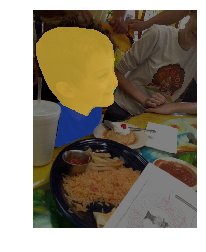

In [7]:
I_vis=I.copy()/2 # Dim the image.

for ann in anns:  
    bbr =  np.array(ann['bbox']).astype(int) # the box.
    print(bbr, ann.keys(), ann["id"])
    if( 'dp_masks' in ann.keys()): # If we have densepose annotation for this ann, 
        Mask = GetDensePoseMask(ann['dp_masks'])
#         print(ann['dp_masks'])
        ################
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] );  y2 = min( [ y2,I.shape[0] ] )
        ################ 
        MaskIm = cv2.resize( Mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
        MaskBool = np.tile((MaskIm==0)[:,:,np.newaxis],[1,1,3])
        #  Replace the visualized mask image with I_vis.
        Mask_vis = cv2.applyColorMap( (MaskIm*15).astype(np.uint8) , cv2.COLORMAP_PARULA)[:,:,:]
        Mask_vis[MaskBool]=I_vis[y1:y2,x1:x2,:][MaskBool]
        I_vis[y1:y2,x1:x2,:] = I_vis[y1:y2,x1:x2,:]*0.3 + Mask_vis*0.7
        print("")

plt.imshow(I_vis[:,:,::-1]); plt.axis('off'); plt.show()

#### Obtain bounding boxes for each body part in the COCO dataset (train and val sets)
The densepose masks will be converted to bboxes and stored in COCO format (http://cocodataset.org/#download).

The person's bbox will be assigned id = 14. If it doesn't contain body parts annotation then "has_dp_masks" is set to "False". The new annotations will be stored in the "coco/annotations" directory with the prefix "body".

In [8]:
# Check out annotations directory
files_to_process = [
    "densepose_coco_2014_minival.json",
    "densepose_coco_2014_valminusminival.json",
    "densepose_coco_2014_train.json"]

os.listdir(coco_folder + "annotations")

['densepose_coco_2014_test.json',
 'densepose_coco_2014_minival.json',
 'annotations_trainval2017.zip',
 'captions_val2017.json',
 'person_keypoints_train2017.json',
 'instances_val2017.json',
 'body_coco_2014_minival.json',
 'person_keypoints_val2017.json',
 'instances_train2017.json',
 'densepose_coco_2014_valminusminival.json',
 'captions_train2017.json',
 'densepose_coco_2014_train.json']

In [9]:
# df = pd.DataFrame(columns=["dp_split", "person", "body_parts", ""])
# i = 0
unique_ann_id = 1
for dp_split in files_to_process:
    print("----")
    
    print("Started processing of {}".format(dp_split))
    path_to_annotation = "/".join((coco_folder, "annotations", dp_split))
    dp_coco = COCO(path_to_annotation)
    new_annotations = {}  # {im_id: new_annotations}
    # Get image indices
    im_ids = sorted(dp_coco.getImgIds())
    
    # Convert masks to bounding boxes for all images
    for im_id in im_ids:
        ann_idx = dp_coco.getAnnIds(imgIds=im_id)
        
        anns = dp_coco.loadAnns(ann_idx)
    
        # Process the masks for each person on the image
        new_im_annotations = []
        for ann in anns:
            
            new_im_annotations.append(
                {
                    u"segmentation": ann["segmentation"],
                    u"area": ann["area"],
                    u"iscrowd": ann["iscrowd"],
                    u"image_id": im_id,
                    u"bbox": ann["bbox"],  # x1, y1, w, h
                    u"category_id": category_to_id["Person"],
                    u"id": unique_ann_id
                }
            )
            unique_ann_id += 1
            
            # If we have densepose annotation for this person
            if('dp_masks' in ann.keys()):
                new_im_annotations[-1]["has_dp_masks"] = True
                part_bbox_dict, part_mask_dict, part_RLEmask_dict, part_area = GetDensePoseBbox(ann['dp_masks'])
                
                for category_id in part_bbox_dict.keys():
                    part_bbox = part_bbox_dict[category_id].tolist()
                    
                    part_bbox[0] = part_bbox[0] * ann["bbox"][2] / 256. + ann["bbox"][0]
                    part_bbox[1] = part_bbox[1] * ann["bbox"][3] / 256. + ann["bbox"][1]
                    part_bbox[2] = part_bbox[2] * ann["bbox"][2] / 256.
                    part_bbox[3] = part_bbox[3] * ann["bbox"][3] / 256.
                    
                    # Convert mask to contour, (x, y) pairs
                    contours, hierarchy = cv2.findContours(
                        (part_mask_dict[category_id]).astype(np.uint8),
                        cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    shifted_contours = []  # Because the contour is inside mask initially
                    for c in contours:
                        temp = c.flatten().tolist()
                        for i in range(len(temp)):
                            if i % 2 == 0:
                                temp[i] = temp[i] * ann["bbox"][2] / 256. + ann["bbox"][0]
                            else:
                                temp[i] = temp[i] * ann["bbox"][3] / 256. + ann["bbox"][1]                                
                        shifted_contours.append(temp)
                        
                    new_im_annotations.append(
                        {
                            u"segmentation": shifted_contours,
                            u"area": float(part_area[category_id]),
                            u"iscrowd": ann["iscrowd"],
                            u"image_id": im_id,
                            u"bbox": part_bbox,
                            u"category_id": category_id,
                            u"id": unique_ann_id
                        }
                    )
                    unique_ann_id += 1
            else:
                new_im_annotations[-1]["has_dp_masks"] = False
        new_annotations[im_id] = new_im_annotations
#         break
    # Save new annotations in COCO format
    new_coco_annotation = {
        u'images': [], u'annotations': [], u'categories': []
    }
    with open(path_to_annotation) as annotation_file:
        original_coco_annotation = json.load(annotation_file)
        
    for i in range(len(original_coco_annotation["images"])):
        im_id = original_coco_annotation["images"][i]["id"]
        if im_id not in new_annotations:
            continue
            
        new_coco_annotation["annotations"] += new_annotations[im_id]
        new_coco_annotation["images"].append(original_coco_annotation["images"][i])
        
        
    for category in category_to_id.keys():
        new_coco_annotation["categories"].append(
            {
                'id': category_to_id[category], 'name': category, 'supercategory': 'body'
            })
    with open("/".join((coco_folder, "annotations", "body_" + dp_split[10:])), 'w') as outfile:
        json.dump(new_coco_annotation, outfile)
        
#     break

----
Started processing of densepose_coco_2014_minival.json
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
----
Started processing of densepose_coco_2014_valminusminival.json
loading annotations into memory...
Done (t=3.18s)
creating index...
index created!
----
Started processing of densepose_coco_2014_train.json
loading annotations into memory...
Done (t=122.69s)
creating index...
index created!


### Check created annotations

In [12]:
dp_coco.loadAnns(dp_coco.getAnnIds(imgIds=im_ids[:4]))

[{u'area': 86145.2971,
  u'bbox': [167.58, 162.89, 310.61, 465.19],
  u'category_id': 1,
  u'dp_I': [2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   10.0,
   24.0,
   23.0,
   24.0,
   23.0,
   24.0,
   24.0,
   23.0,
   24.0,
   24.0,
   23.0,
   24.0,
   24.0,
   23.0,
   2.0,
   1.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   15.0,
   18.0,
   16.0,
   18.0,
   16.0,
   18.0,
   18.0,
   16.0,
   18.0,
   16.0,
   18.0,
   16.0,
   18.0,
   16.0,
   22.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   19.0,
   21.0,
   19.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   3.0,
   4.0,
   4.0,
   4.0,
   4.0,
   4.0,
   21.0],
  u'dp_U': [0.07984049618244171,


In [13]:
anns[0].keys()

[u'segmentation',
 u'num_keypoints',
 u'dp_masks',
 u'area',
 u'iscrowd',
 u'dp_I',
 u'keypoints',
 u'id',
 u'dp_U',
 u'image_id',
 u'dp_V',
 u'bbox',
 u'category_id',
 u'dp_y',
 u'dp_x']

In [14]:
# d = json.load(open(coco_folder + 'annotations/instances_val2017.json'))
# d = json.load(open(coco_folder + 'annotations/densepose_coco_2014_minival.json'))
d = json.load(open(coco_folder + 'annotations/body_coco_2014_minival.json'))

In [15]:
d.keys()

[u'images', u'annotations', u'categories']

In [16]:
d["categories"]

[{u'id': 8, u'name': u'LowerLegLeft', u'supercategory': u'body'},
 {u'id': 12, u'name': u'LowerArmRight', u'supercategory': u'body'},
 {u'id': 9, u'name': u'UpperArmLeft', u'supercategory': u'body'},
 {u'id': 3, u'name': u'LeftFoot', u'supercategory': u'body'},
 {u'id': 14, u'name': u'Person', u'supercategory': u'body'},
 {u'id': 5, u'name': u'UpperLegRight', u'supercategory': u'body'},
 {u'id': 2, u'name': u'LeftHand', u'supercategory': u'body'},
 {u'id': 4, u'name': u'RightFoot', u'supercategory': u'body'},
 {u'id': 13, u'name': u'Head', u'supercategory': u'body'},
 {u'id': 1, u'name': u'RightHand', u'supercategory': u'body'},
 {u'id': 0, u'name': u'Torso', u'supercategory': u'body'},
 {u'id': 10, u'name': u'UpperArmRight', u'supercategory': u'body'},
 {u'id': 7, u'name': u'LowerLegRight', u'supercategory': u'body'},
 {u'id': 6, u'name': u'UpperLegLeft', u'supercategory': u'body'},
 {u'id': 11, u'name': u'LowerArmLeft', u'supercategory': u'body'}]

In [17]:
print(len(d["images"]), len(d["annotations"]))
d["images"]

(1508, 27454)


[{u'coco_url': u'http://mscoco.org/images/458755',
  u'date_captured': u'2013-11-16 23:06:51',
  u'file_name': u'COCO_val2014_000000458755.jpg',
  u'flickr_url': u'http://farm6.staticflickr.com/5119/5878453277_eea657a01d_z.jpg',
  u'height': 480,
  u'id': 458755,
  u'license': 1,
  u'width': 640},
 {u'coco_url': u'http://mscoco.org/images/532493',
  u'date_captured': u'2013-11-20 18:05:25',
  u'file_name': u'COCO_val2014_000000532493.jpg',
  u'flickr_url': u'http://farm9.staticflickr.com/8036/8027793561_893d2d9f45_z.jpg',
  u'height': 408,
  u'id': 532493,
  u'license': 3,
  u'width': 640},
 {u'coco_url': u'http://mscoco.org/images/554328',
  u'date_captured': u'2013-11-19 18:25:43',
  u'file_name': u'COCO_val2014_000000554328.jpg',
  u'flickr_url': u'http://farm5.staticflickr.com/4149/5072971882_8bb1f01b18_z.jpg',
  u'height': 499,
  u'id': 554328,
  u'license': 1,
  u'width': 640},
 {u'coco_url': u'http://mscoco.org/images/88970',
  u'date_captured': u'2013-11-21 01:39:31',
  u'file_

In [18]:
d["annotations"][0].keys()

[u'segmentation',
 u'has_dp_masks',
 u'area',
 u'iscrowd',
 u'image_id',
 u'bbox',
 u'category_id',
 u'id']

In [19]:
d["annotations"][0]["area"]

117599.5149

In [20]:
d["annotations"][0]["bbox"]

[69.03, 37.75, 508.05, 435.78]